# FEATURE DESCRIPTON
Relevant Information:

   The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 

Number of Instances: 45211 for bank-full.csv

Number of Attributes: 16 + output attribute.

Attribute information:

   Input variables:
   ##### bank client data:
   1. - age (numeric)
   2. - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
   3. - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4. - education (categorical: "unknown","secondary","primary","tertiary")
   5. - default: has credit in default? (binary: "yes","no")
   6. - balance: average yearly balance, in euros (numeric) 
   7. - housing: has housing loan? (binary: "yes","no")
   8. - loan: has personal loan? (binary: "yes","no")
   ##### related with the last contact of the current campaign:
   9. - contact: contact communication type (categorical: "unknown","telephone","cellular")
   10. - day: last contact day of the month (numeric)
   11. - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   12. - duration: last contact duration, in seconds (numeric)
   ##### other attributes:
   13. - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   14. - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   15. - previous: number of contacts performed before this campaign and for this client (numeric)
   16. - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
   17. - y - has the client subscribed a term deposit? (binary: "yes","no")

# OVERVIEW

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')


## LOAD DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/MyDrive/data/bank-full.csv', delimiter=';')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# PREPROCESSING

## MISSING VALUES HANDLING

In [6]:
df = df.drop(columns=['contact', 'day', 'month', 'previous', 'pdays'])

In [7]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
duration     0
campaign     0
poutcome     0
y            0
dtype: int64

In [8]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')

## OUTLIER HANDLING

In [9]:
def find_outliers(data):
    Q1 = data.quantile(.25)
    Q3 = data.quantile(.75)
    
    IQR = Q3 - Q1

    min_IQR = Q1 - 1.5 * IQR
    max_IQR = Q3 + 1.5 * IQR
    
    low_out = []
    upper_out = []
    
    for i in data:
        if(i < min_IQR):
            low_out.append(i)
        if(i > max_IQR):
            upper_out.append(i)
            
    return low_out, upper_out

In [10]:
def outlierinfo(dataframe, feature):
    lower_out = find_outliers(dataframe[feature])[0]
    upper_out = find_outliers(dataframe[feature])[1]
    
    print(f'Jumlah Outlier = {len(lower_out) + len(upper_out)}')
    persen_out = (len(lower_out) + len(upper_out))/len(dataframe)*100
    print(f'Presentasi Outlier = {round(persen_out, 2)}%')
    
    iqr = dataframe[feature].quantile(.75) - dataframe[feature].quantile(.25)   
    upper_limit = dataframe[feature].quantile(.75) + 1.5 * iqr
    print('Upper_limit', upper_limit)
    print('\n')
    
    j = 0
    for i in range(10):
        print(f'quantile {0.90+j} = {dataframe[feature].quantile(0.90 + j)}')
        j += 0.01

### age

In [11]:
var = 'age'

In [12]:
outlierinfo(df_num, var)

Jumlah Outlier = 487
Presentasi Outlier = 1.08%
Upper_limit 70.5


quantile 0.9 = 56.0
quantile 0.91 = 57.0
quantile 0.92 = 57.0
quantile 0.93 = 58.0
quantile 0.9400000000000001 = 58.0
quantile 0.9500000000000001 = 59.0
quantile 0.9600000000000001 = 59.0
quantile 0.97 = 60.0
quantile 0.98 = 63.0
quantile 0.99 = 71.0


In [13]:
df_num[f'{var}_win'] = stats.mstats.winsorize(df[var], limits=(0.0,0.02))

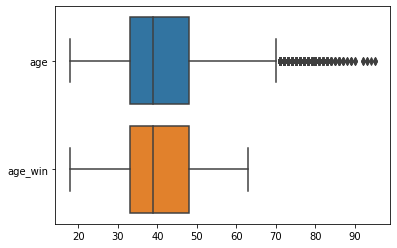

In [14]:
sns.boxplot(data = df_num[[var, f'{var}_win']], orient='h')

### balance

In [15]:
var = 'balance'

In [16]:
outlierinfo(df_num, var)

Jumlah Outlier = 4729
Presentasi Outlier = 10.46%
Upper_limit 3462.0


quantile 0.9 = 3574.0
quantile 0.91 = 3864.2999999999956
quantile 0.92 = 4260.400000000009
quantile 0.93 = 4687.300000000003
quantile 0.9400000000000001 = 5134.599999999977
quantile 0.9500000000000001 = 5768.0
quantile 0.9600000000000001 = 6572.600000000006
quantile 0.97 = 7777.89999999998
quantile 0.98 = 9439.3999999999
quantile 0.99 = 13164.900000000001


In [17]:
df_num['balance'].quantile(0.89)

3321.0

In [18]:
df_num[f'{var}_win'] = stats.mstats.winsorize(df[var], limits=(0.0,0.11))

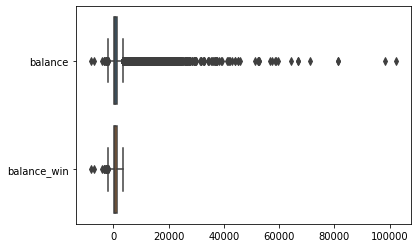

In [19]:
sns.boxplot(data = df_num[[var, f'{var}_win']], orient='h')

### duration

In [20]:
var = 'duration'

In [21]:
outlierinfo(df_num, var)

Jumlah Outlier = 3235
Presentasi Outlier = 7.16%
Upper_limit 643.0


quantile 0.9 = 548.0
quantile 0.91 = 579.0
quantile 0.92 = 612.0
quantile 0.93 = 650.0
quantile 0.9400000000000001 = 696.0
quantile 0.9500000000000001 = 751.0
quantile 0.9600000000000001 = 823.0
quantile 0.97 = 914.6999999999971
quantile 0.98 = 1051.0
quantile 0.99 = 1269.0


In [22]:
df_num[f'{var}_win'] = stats.mstats.winsorize(df[var], limits=(0.0,0.08))

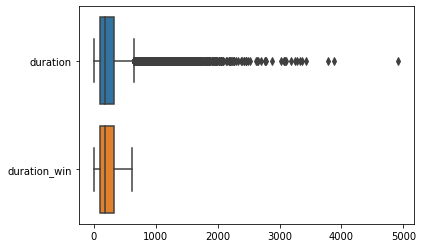

In [23]:
sns.boxplot(data = df_num[[var, f'{var}_win']], orient='h')

### campaign

In [24]:
var = 'campaign'

In [25]:
outlierinfo(df_num, var)

Jumlah Outlier = 3064
Presentasi Outlier = 6.78%
Upper_limit 6.0


quantile 0.9 = 5.0
quantile 0.91 = 6.0
quantile 0.92 = 6.0
quantile 0.93 = 6.0
quantile 0.9400000000000001 = 7.0
quantile 0.9500000000000001 = 8.0
quantile 0.9600000000000001 = 8.0
quantile 0.97 = 10.0
quantile 0.98 = 12.0
quantile 0.99 = 16.0


In [26]:
df_num[f'{var}_win'] = stats.mstats.winsorize(df[var], limits=(0.0,0.10))

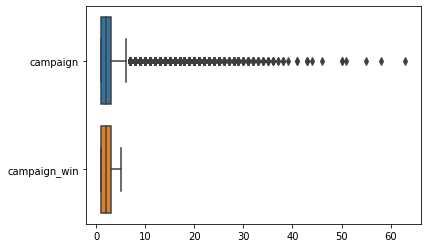

In [27]:
sns.boxplot(data = df_num[[var, f'{var}_win']], orient='h')

# EDA

## TARGET FEATURE

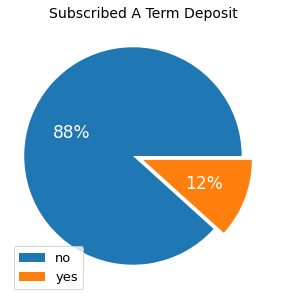

In [28]:
plt.figure(figsize = (5,5))
plt.title('Subscribed A Term Deposit', fontsize = 14)

labels = 'no', 'yes'

plt.pie(df['y'].value_counts(), autopct = '%.0f%%', 
        textprops = {'fontsize' : 17, 'color' : 'white'}, explode = (0.1,0))

plt.legend(labels, loc='lower left', fontsize = 13)

plt.show()

In [29]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

> - From the output obtained, there are 5289 (11.70%) who are subscribed, while those who are not subscribed are 39922 (88.3%)

## NUMERICAL FEATURES

In [30]:
def plotNumerical(dataframe, column):
    plt.figure(figsize = (8,4))
    ax = sns.distplot(dataframe[(dataframe['y'] == 'no')][column])
    ax = sns.distplot(dataframe[(dataframe['y'] == 'yes')][column])
    ax.legend(['No', 'Yes'])
    
    plt.xlabel(column, fontsize = 12) 
    plt.title('Distribution of Subscribed A Term Deposit by '+column, fontsize = 15)
    
    plt.tight_layout()
    plt.show()

    data = pd.crosstab(df[column],df["y"])
    data["yes percentage"] = 100*data["yes"]/(data["yes"]+data["no"])
    data["no percentage"] = 100*data["no"]/(data["yes"]+data["no"])
    
    return data.sort_values(by=["yes", "yes percentage"], ascending=False)

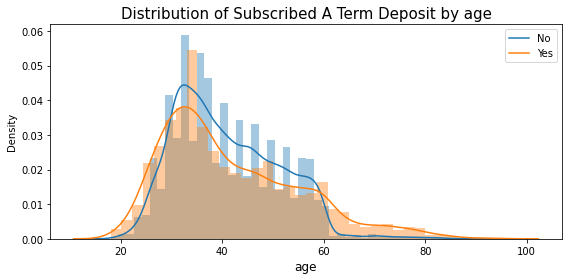

y,no,yes,yes percentage,no percentage
age,,,,
32,1864,221,10.599520,89.400480
30,1540,217,12.350598,87.649402
33,1762,210,10.649087,89.350913
35,1685,209,11.034847,88.965153
31,1790,206,10.320641,89.679359
...,...,...,...,...
93,0,2,100.000000,0.000000
95,1,1,50.000000,50.000000
88,2,0,0.000000,100.000000


In [31]:
plotNumerical(df, 'age')

>Based on the age distribution table, it can be seen that yes the percentage will be large in the age range > 60.

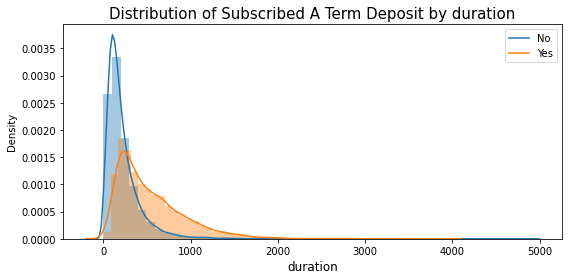

y,no,yes,yes percentage,no percentage
duration,,,,
261,54,19,26.027397,73.972603
226,101,17,14.406780,85.593220
229,71,16,18.390805,81.609195
232,74,16,17.777778,82.222222
187,104,16,13.333333,86.666667
...,...,...,...,...
3322,1,0,0.000000,100.000000
3366,1,0,0.000000,100.000000
3422,1,0,0.000000,100.000000


In [32]:
plotNumerical(df, 'duration')

> The last contact duration in seconds seems successful enough to attract deposit customers at more than 537 seconds. This makes sense because when the communication is long, it proves that the intended person is someone who is interested in the deposit campaign.

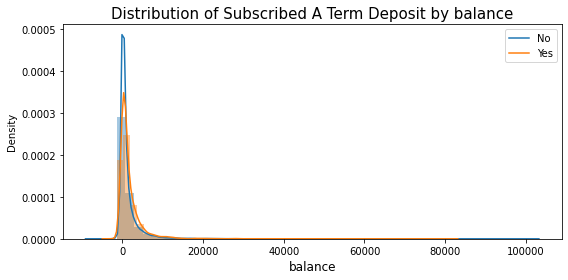

y,no,yes,yes percentage,no percentage
balance,,,,
0,3222,292,8.309619,91.690381
1,178,17,8.717949,91.282051
2,140,16,10.256410,89.743590
5,98,15,13.274336,86.725664
294,22,12,35.294118,64.705882
...,...,...,...,...
66653,1,0,0.000000,100.000000
66721,1,0,0.000000,100.000000
71188,1,0,0.000000,100.000000


In [33]:
plotNumerical(df, 'balance')

> The highest contribution is at the average annual balance of 0. There are 292 customers who are deposit customers at balance = 0.

## CATEGORICAL FEATURES

In [34]:
def subsribe_rate_cat_plot(column, annot=True):
    unique = df[column].unique()
    nilai_plot= {}
    
    plt.figure(figsize=(15,5))
    ax = sns.countplot(x = column, data = df, hue = 'y')
        
    plt.tight_layout()
    plt.show()
    
    new = pd.crosstab(df[column], df['y'])
    new['ratio']=(new['yes']/new['no'])*100
    return new.sort_values(by=['ratio'], ascending=False)

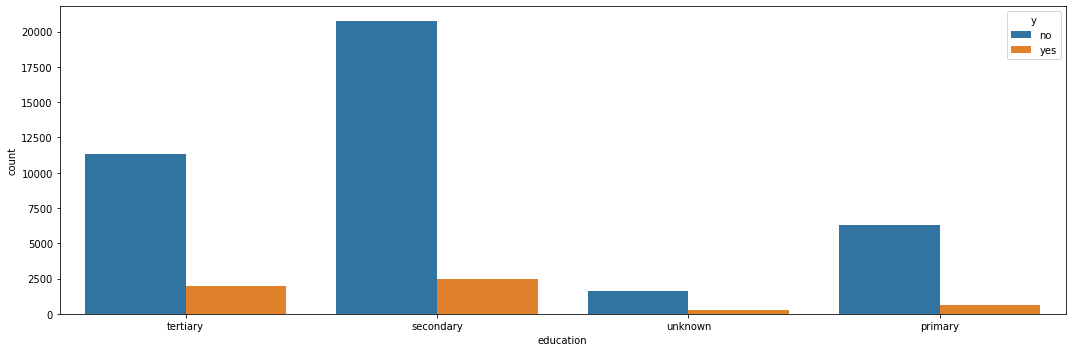

y,no,yes,ratio
education,,,
tertiary,11305,1996,17.655904
unknown,1605,252,15.700935
secondary,20752,2450,11.806091
primary,6260,591,9.440895


In [35]:
subsribe_rate_cat_plot('education')

> The clients who subscribe the most are clients with secondary education qualifications as much as 2450 and a percentage rate of 11.80% and clients who subscribe the least, namely clients with primary education qualifications as many as 591 and a percentage rate of 9.44%, so it can be assumed that the higher the education, the greater the tendency of a person to subscribe.

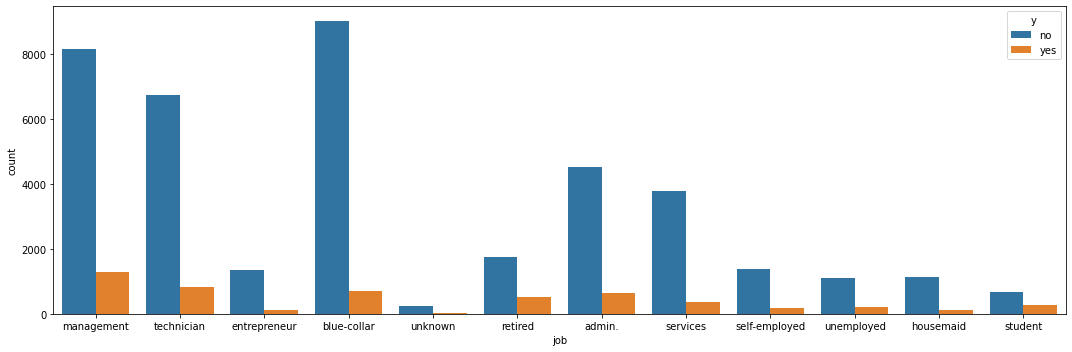

y,no,yes,ratio
job,,,
student,669,269,40.209268
retired,1748,516,29.519451
unemployed,1101,202,18.346957
management,8157,1301,15.949491
admin.,4540,631,13.898678
self-employed,1392,187,13.433908
unknown,254,34,13.385827
technician,6757,840,12.431552
services,3785,369,9.749009


In [36]:
subsribe_rate_cat_plot('job')

> The clients who subscribe the most are clients who work as management as many as 1301 and a percentage rate of 15.94% and the clients who subscribe the least are clients who work as house maids as many as 109 and a percentage rate of 9.63%. So it can be assumed that the higher the level of a person's job, it can affect someone to subscribe.

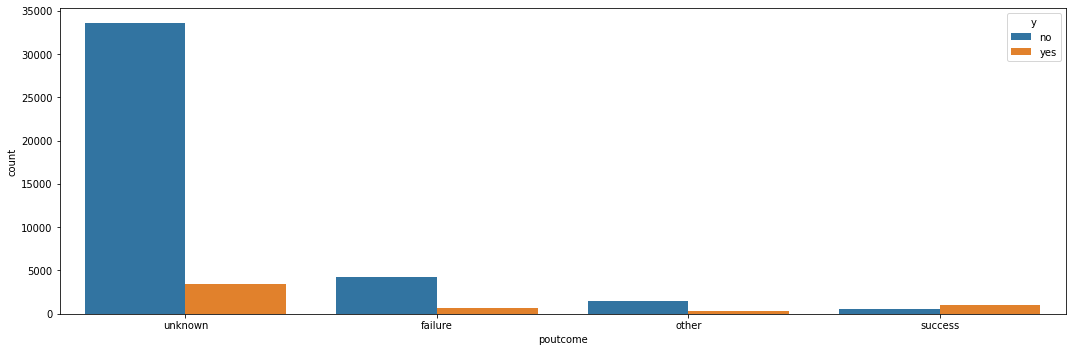

y,no,yes,ratio
poutcome,,,
success,533,978,183.489681
other,1533,307,20.026093
failure,4283,618,14.429138
unknown,33573,3386,10.085485


In [37]:
subsribe_rate_cat_plot('poutcome')

> The clients who subscribe the most where marketing campaign were successful as many as 978 clients, so it can be assumed that when the previous marketing campaign was successful, the more likely it is that someone to subscribe.

# FEATURE ENGINEERING

## FEATURE ENCODING

### ONE HOT ENCODING

In [38]:
df_cat = pd.get_dummies(df_cat, prefix='job', columns=['job'])
df_cat = pd.get_dummies(df_cat, prefix='marital', columns=['marital'])
df_cat = pd.get_dummies(df_cat, prefix='default', columns=['default'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='housing', columns=['housing'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='loan', columns=['loan'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='poutcome', columns=['poutcome'])

In [39]:
df_cat.columns

Index(['education', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'default_yes', 'housing_yes', 'loan_yes', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

### ORDINAL ENCODING

In [40]:
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
df_cat['education_enc'] = OrdinalEncoder(categories=[education_order]).fit_transform(df_cat[['education']])
df_cat = df_cat.drop(columns=['education'])

### TARGET ENCODING

In [41]:
df_cat['y'] = LabelEncoder().fit_transform(df_cat[['y']])

## FEATURE SCALLING

In [42]:
df_num.columns

Index(['age', 'balance', 'duration', 'campaign', 'age_win', 'balance_win',
       'duration_win', 'campaign_win'],
      dtype='object')

In [43]:
df_num = df_num.drop(columns=['age','balance','duration','campaign'])

In [44]:
scaler = MinMaxScaler()
print(scaler)

MinMaxScaler()


In [45]:
for i in df_num:
    df_num[f'{i}_minmax'] = scaler.fit_transform(df_num[[i]])

In [46]:
df_num.columns

Index(['age_win', 'balance_win', 'duration_win', 'campaign_win',
       'age_win_minmax', 'balance_win_minmax', 'duration_win_minmax',
       'campaign_win_minmax'],
      dtype='object')

In [47]:
df_num = df_num.drop(columns=['age_win', 'balance_win', 'duration_win', 'campaign_win'])

## FEATURE SELECTION

In [48]:
df_ft = pd.concat([df_num, df_cat], axis=1).reset_index(drop=True)

In [49]:
df_ft.head()

,age_win_minmax,balance_win_minmax,duration_win_minmax,campaign_win_minmax,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,marital_married,marital_single,default_yes,housing_yes,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,education_enc
0,0.888889,0.896120,0.426471,0.0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,3.0
1,0.577778,0.709700,0.246732,0.0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,2.0
2,0.333333,0.707319,0.124183,0.0,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,1,2.0
3,0.644444,0.839947,0.150327,0.0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0.0
4,0.333333,0.707231,0.323529,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0.0


In [50]:
x = df_ft.drop(columns=['y']) #independent feature
y = df_ft['y'] #target

[0.17611938 0.18287217 0.30773944 0.06169889 0.00817864 0.00669835
 0.0044108  0.00376687 0.00825221 0.00588172 0.00504061 0.00623183
 0.00501697 0.00871927 0.0048884  0.00161328 0.00584554 0.0075045
 0.00700579 0.00324481 0.02536467 0.01309096 0.01003679 0.00681831
 0.05802989 0.02119796 0.04473196]


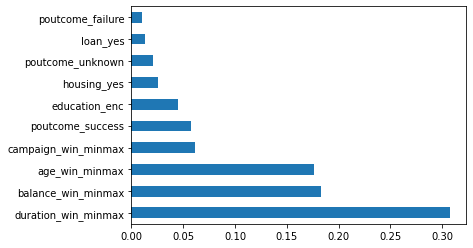

In [51]:
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [52]:
df_slc = pd.DataFrame()
df_slc = df_ft[feat_importances.nlargest(10).index]
df_slc = df_slc.drop(columns=['poutcome_unknown'])

In [53]:
df_slc['y'] = df_ft['y']

# MODELLING

In [54]:
df_slc.head()

,duration_win_minmax,balance_win_minmax,age_win_minmax,campaign_win_minmax,poutcome_success,education_enc,housing_yes,loan_yes,poutcome_failure,y
0,0.426471,0.896120,0.888889,0.0,0,3.0,1,0,0,0
1,0.246732,0.709700,0.577778,0.0,0,2.0,1,0,0,0
2,0.124183,0.707319,0.333333,0.0,0,2.0,1,1,0,0
3,0.150327,0.839947,0.644444,0.0,0,0.0,1,0,0,0
4,0.323529,0.707231,0.333333,0.0,0,0.0,0,0,0,0


## LOGISTIC REGRESSION

In [55]:
X = df_slc.drop(columns=['y', 'housing_yes'])
y = df_slc['y']

In [56]:
# tarin test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #size test 20%

In [57]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

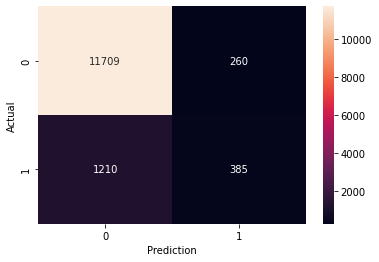

In [58]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [59]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11969
           1       0.60      0.24      0.34      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.61      0.64     13564
weighted avg       0.87      0.89      0.87     13564



> Here we choose precision to optimize because we think FP is more important to optimize. because the model predicts unsubscribed customers are already subscribed, which means their future campaigns won't be opted in to the campaign.

In [60]:
def cv_score(model, data_x, data_y, scoring, n):
    
    cv = KFold(n_splits=n, shuffle=False)
    scores_train = cross_val_score(model, data_x, data_y, scoring=scoring, cv=cv)
    scores_test = cross_validate(model, data_x, data_y, cv=n)

    plt.figure(figsize=(7,5))
    sns.lineplot(data=scores_train, label='Train', marker='o')
    sns.lineplot(data=scores_test['test_score'], label='Test', marker='o')
    plt.show()
    
    return pd.DataFrame(data = [scores_train.mean()*100, scores_test['test_score'].mean()*100],
                        index = ['Train', 'Test'],
                        columns =['Score (%)']
                       )
    

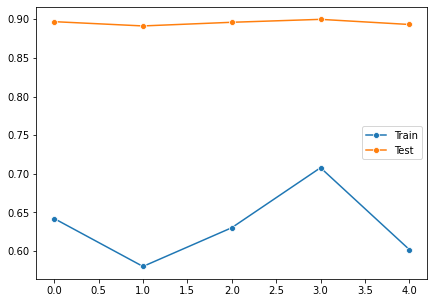

,Score (%)
Train,63.246608
Test,89.544041


In [61]:
cv_score(model_lr, X_train, y_train, 'precision', 5)

> The difference in K-Fold Train and Test scores is more than 10%, so it can be concluded that the model is overfit.

## LOGISTIC REGRESSION HYPERPARAMETER TUNING

In [62]:
param = [{'solver' : ['saga'],
          'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
          'max_iter' : [10,100], 
          'C' : [0.01, 0.1, 1], 
          'l1_ratio' : [0,1]},
         
          {'solver' : ['newton-cg', 'lbfgs'],
           'penalty' : ['l2','none'],
           'max_iter' : [10,100],
           'C' : [0.01, 0.1, 1],
           'l1_ratio' : [0,1]}]


In [63]:
lr_gs = GridSearchCV(estimator= model_lr, param_grid=param, cv=5, scoring='precision')

In [64]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1], 'l1_ratio': [0, 1],
                          'max_iter': [10, 100],
                          'penalty': ['elasticnet', 'l1', 'l2', 'none'],
                          'solver': ['saga']},
                         {'C': [0.01, 0.1, 1], 'l1_ratio': [0, 1],
                          'max_iter': [10, 100], 'penalty': ['l2', 'none'],
                          'solver': ['newton-cg', 'lbfgs']}],
             scoring='precision')

In [65]:
lr_gs.best_params_

{'C': 0.01, 'l1_ratio': 0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

In [66]:
model_lr_tuned = LogisticRegression(C=0.01, l1_ratio=0, max_iter=10, penalty='l2', solver='lbfgs') 

In [67]:
model_lr_tuned.fit(X_train, y_train)

LogisticRegression(C=0.01, l1_ratio=0, max_iter=10)

In [68]:
y_pred_lr_tuned = model_lr_tuned.predict(X_test)

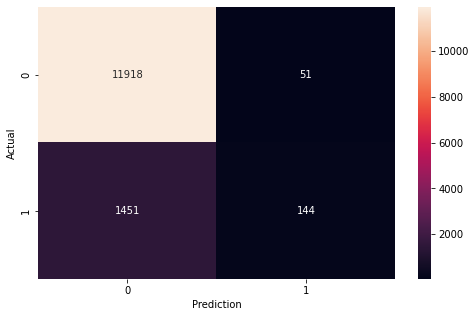

In [69]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr_tuned), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [70]:
print(classification_report(y_test, y_pred_lr_tuned))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11969
           1       0.74      0.09      0.16      1595

    accuracy                           0.89     13564
   macro avg       0.81      0.54      0.55     13564
weighted avg       0.87      0.89      0.85     13564



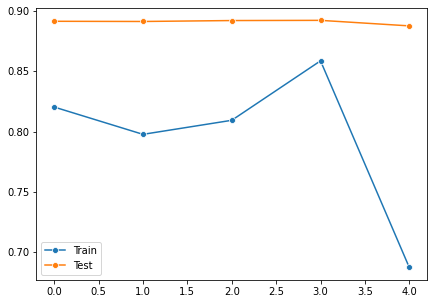

,Score (%)
Train,79.484650
Test,89.111129


In [71]:
cv_score(model_lr_tuned, X_train, y_train, 'precision', 5)

> Based on the information above, it can be seen that the difference in the logistic regression score of the kfold train test with hyperparameter tuning is less than 10% which indicates that the model is neither overfit nor underfit.

## GRADIENT BOOSTING


In [72]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

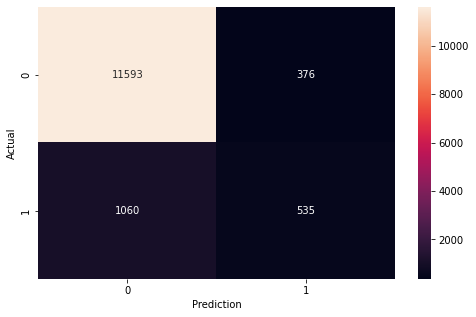

In [73]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [74]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11969
           1       0.59      0.34      0.43      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.65      0.68     13564
weighted avg       0.88      0.89      0.88     13564



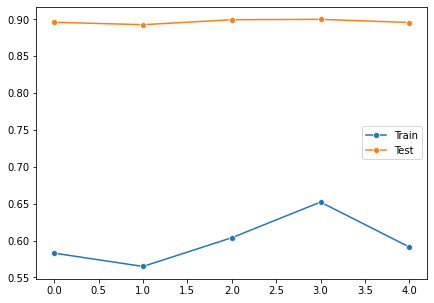

,Score (%)
Train,59.901290
Test,89.679922


In [75]:
cv_score(model_gb, X_train, y_train, 'precision', 5)

> The difference in K-Fold Train and Test scores is more than 10%, so it can be concluded that the model is overfit.

## GRADIENT BOOSTING HYPERPARAMETER TUNING

In [91]:
param = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

gb_gs = GridSearchCV(estimator= model_gb, param_grid=param, cv=5, scoring='precision')

In [92]:
gb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]},
             scoring='precision')

In [93]:
gb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 5}

In [94]:
model_gb_tuned = GradientBoostingClassifier(n_estimators=5, max_depth=7, learning_rate=0.1)

In [95]:
model_gb_tuned.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=5)

In [96]:
y_pred_gb_tuned = model_gb_tuned.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred_gb_tuned))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     11969
           1       0.64      0.01      0.02      1595

    accuracy                           0.88     13564
   macro avg       0.76      0.50      0.48     13564
weighted avg       0.85      0.88      0.83     13564



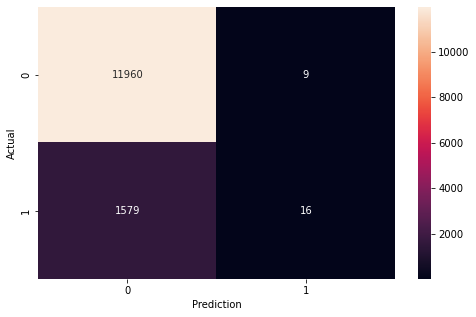

In [98]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gb_tuned), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

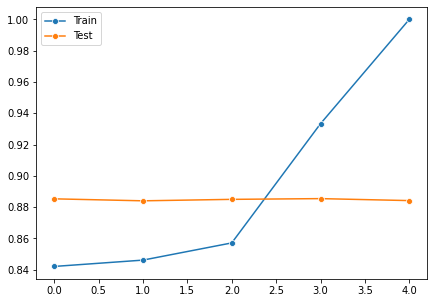

,Score (%)
Train,89.574706
Test,88.479161


In [99]:
cv_score(model_gb_tuned, X_train, y_train, 'precision', 5)

> Based on the information above, it can be seen that the difference in the Gradient Boosting score of the kfold train test with hyperparameter tuning is less than 10% which indicates that the model is neither overfit nor underfit.

## MODEL EVALUATION

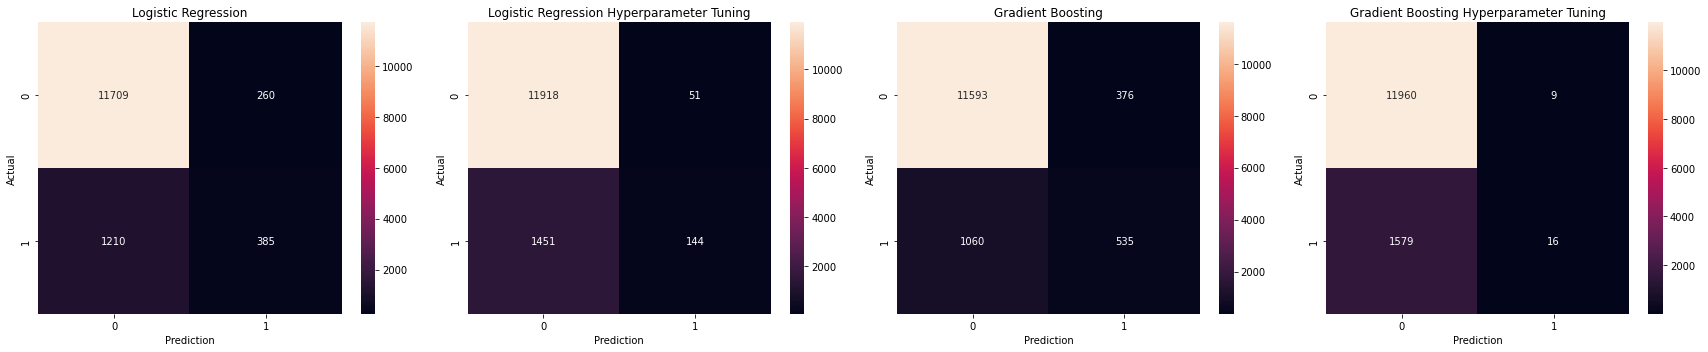

In [100]:
f, ax = plt.subplots(1, 4, figsize=(24,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='.0f', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred_lr_tuned), annot=True, fmt='.0f', ax=ax[1])
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='.0f', ax=ax[2])
sns.heatmap(confusion_matrix(y_test, y_pred_gb_tuned), annot=True, fmt='.0f', ax=ax[3])

for i in range(4):
  ax[i].set_xlabel('Prediction')
  ax[i].set_ylabel('Actual')

ax[0].set_title('Logistic Regression')
ax[1].set_title('Logistic Regression Hyperparameter Tuning')
ax[2].set_title('Gradient Boosting')
ax[3].set_title('Gradient Boosting Hyperparameter Tuning')

plt.tight_layout()
plt.show()

In [101]:
print('Logistic Regression')
print(classification_report(y_test, y_pred_lr))
print('\nLogistic Regression Hyperparameter Tuning')
print(classification_report(y_test, y_pred_lr_tuned))
print('\nGradient Boosting')
print(classification_report(y_test, y_pred_gb))
print('\nGradient Boosting Hyperparameter Tuning')
print(classification_report(y_test, y_pred_gb_tuned))

Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11969
           1       0.60      0.24      0.34      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.61      0.64     13564
weighted avg       0.87      0.89      0.87     13564


Logistic Regression Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11969
           1       0.74      0.09      0.16      1595

    accuracy                           0.89     13564
   macro avg       0.81      0.54      0.55     13564
weighted avg       0.87      0.89      0.85     13564


Gradient Boosting
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11969
           1       0.59      0.34      0.43      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.65      0.68   

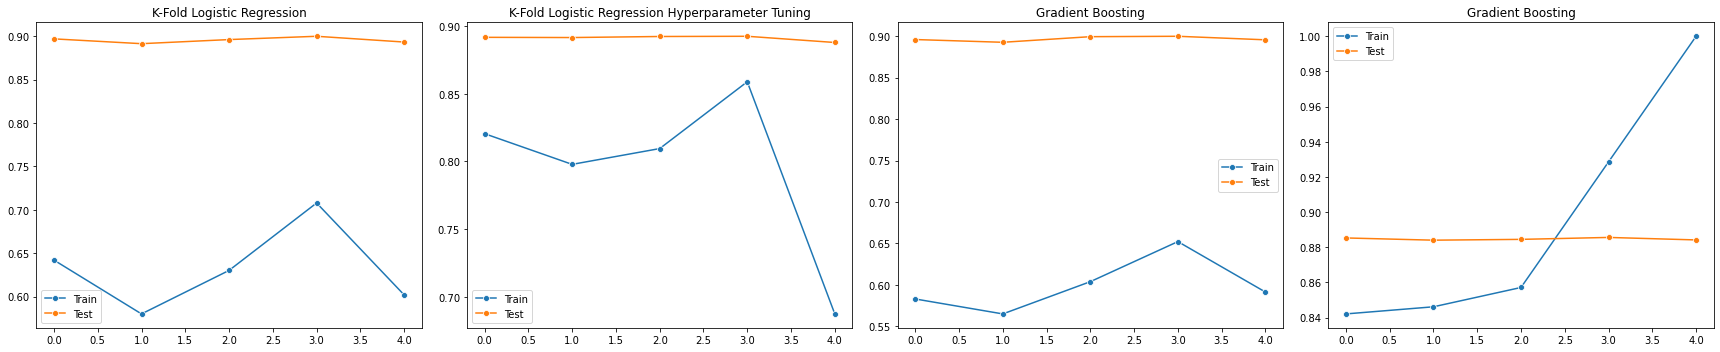

In [102]:

cv = KFold(n_splits=5, shuffle=False)
f, ax = plt.subplots(1,4, figsize=(24,5))

# kfold logistic regression
scores_train1 = cross_val_score(model_lr, X_train, y_train, scoring='precision', cv=cv)
scores_test1 = cross_validate(model_lr, X_train, y_train, cv=5)
sns.lineplot(data=scores_train1, label='Train', marker='o', ax=ax[0])
sns.lineplot(data=scores_test1['test_score'], label='Test', marker='o', ax=ax[0])
ax[0].set_title('K-Fold Logistic Regression')

# kfold logistic regression hyperparameter tuning
scores_train2 = cross_val_score(model_lr_tuned, X_train, y_train, scoring='precision', cv=cv)
scores_test2 = cross_validate(model_lr_tuned, X_train, y_train, cv=5)
sns.lineplot(data=scores_train2, label='Train', marker='o', ax=ax[1])
sns.lineplot(data=scores_test2['test_score'], label='Test', marker='o', ax=ax[1])
ax[1].set_title('K-Fold Logistic Regression Hyperparameter Tuning')

# kfold gradient boosting
scores_train3 = cross_val_score(model_gb, X_train, y_train, scoring='precision', cv=cv)
scores_test3 = cross_validate(model_gb, X_train, y_train, cv=5)
sns.lineplot(data=scores_train3, label='Train', marker='o', ax=ax[2])
sns.lineplot(data=scores_test3['test_score'], label='Test', marker='o', ax=ax[2])
ax[2].set_title('Gradient Boosting')

# kfold gradient boosting
scores_train4 = cross_val_score(model_gb_tuned, X_train, y_train, scoring='precision', cv=cv)
scores_test4 = cross_validate(model_gb_tuned, X_train, y_train, cv=5)
sns.lineplot(data=scores_train4, label='Train', marker='o', ax=ax[3])
sns.lineplot(data=scores_test4['test_score'], label='Test', marker='o', ax=ax[3])
ax[3].set_title('Gradient Boosting')

plt.tight_layout()
plt.show()

In [103]:
pd.DataFrame({
    '[Logistic Regression]' : [round(scores_train1.mean()*100, 2), round(scores_test1['test_score'].mean()*100, 2)],
    '[Logistic Regression Hyperparameter tuning]' : [round(scores_train2.mean()*100, 2), round(scores_test2['test_score'].mean()*100, 2)],
    '[Gradient Boosting]' : [round(scores_train3.mean()*100, 2), round(scores_test3['test_score'].mean()*100, 2)],
    '[Gradient Boosting Hyperparameter tuning]' : [round(scores_train4.mean()*100, 2), round(scores_test4['test_score'].mean()*100, 2)]
}, index = ['Train', 'Test'])

,[Logistic Regression],[Logistic Regression Hyperparameter tuning],[Gradient Boosting],[Gradient Boosting Hyperparameter tuning]
Train,63.25,79.48,59.90,89.48
Test,89.54,89.11,89.68,88.47


> Based on the comparison above, it can be seen that the model that gives the best results gradient boosting + hyperparameter tuning. 

# CONCLUSION
> 

> 1. There are 5289 (11.70%) clients who are subscribed, while those who are not subscribed are 39922 (88.3%)
> 2. The last contact duration in seconds seems successful enough to attract deposit customers at more than 537 seconds. 
> 3. Based on the age distribution table, it can be seen that yes the percentage will be large in the age range > 60.
> 4. The last contact duration in seconds seems successful enough to attract deposit customers at more than 537 seconds. This makes sense because when the communication is long, it proves that the intended person is someone who is interested in the deposit campaign.
> 5. The highest contribution is at the average annual balance of 0. There are 292 customers who are deposit customers at balance = 0.
> 6. The clients who subscribe the most are clients with secondary education qualifications as much as 2450 and a percentage rate of 11.80% and clients who subscribe the least, namely clients with primary education qualifications as many as 591 and a percentage rate of 9.44%, so it can be assumed that the higher the education, the greater the tendency of a person to subscribe.
> 7. The clients who subscribe the most are clients who work as management as many as 1301 and a percentage rate of 15.94% and the clients who subscribe the least are clients who work as house maids as many as 109 and a percentage rate of 9.63%. So it can be assumed that the higher the level of a person's job, it can affect someone to subscribe.
> 8. The clients who subscribe the most where marketing campaign were successful as many as 978 clients, so it can be assumed that when the previous marketing campaign was successful, the more likely it is that someone to subscribe.
> 9. Based on the comparison above, it can be seen that the model that gives the best results gradient boosting + hyperparameter tuning. 